In [6]:
import torch
from torch import Tensor
from torch import optim
from jaxtyping import Float
from PIL import Image, ImageDraw

def visualize_circles_image(circle_positions: Float[Tensor, "num_circles 2"], radii: Float[Tensor, "num_circles"], image_size = 256):
    image = Image.new("RGB", (image_size, image_size), "white")
    draw = ImageDraw.Draw(image)
    
    centers = (circle_positions * image_size).detach().cpu().numpy()
    radii = radii.detach().cpu().numpy() * image_size
    
    for center, radius in zip(centers, radii):
        draw.circle(center, radius, fill="black")
    return image
    

def get_overlap_loss(
    circle_positions: Float[Tensor, "batch num_circles 2"],
    radii: Float[Tensor, "batch num_circles"],
    eps=1e-6,
) -> Float[Tensor, "batch"]:
    num_circles = radii.shape[1]
    assert circle_positions.shape[1] == num_circles

    circle_positions = circle_positions.unsqueeze(2)
    circle_positions = circle_positions.repeat(1, 1, num_circles, 1)
    circle_positions_transposed = circle_positions.transpose(1, 2)

    distances = torch.norm(circle_positions - circle_positions_transposed, p=2, dim=3)

    radii = radii.unsqueeze(1)
    radii = radii.repeat(1, num_circles, 1)

    min_distance = radii + radii.transpose(1, 2) + eps

    min_distance = torch.tril(min_distance, diagonal=-1)

    return torch.relu(min_distance - distances).sum(dim=[1, 2])


def get_image_overflow_loss(
    circle_positions: Float[Tensor, "batch num_circles 2"],
    radii: Float[Tensor, "batch num_circles"],
) -> Float[Tensor, "batch"]:
    num_circles = radii.shape[1]
    batch_size = radii.shape[0]
    assert circle_positions.shape[1] == num_circles
    assert circle_positions.shape[0] == batch_size

    radii_unsqueezed = radii.reshape(batch_size, num_circles, 1).repeat(1, 1, 2)

    overflow_low = torch.relu(radii_unsqueezed - circle_positions)
    overflow_high = torch.relu(circle_positions + radii_unsqueezed - 1.0)

    return overflow_low.sum(dim=[1,2]) + overflow_high.sum(dim=[1,2])


def generate_centers_and_radiuses(
    batch_size: int = 40,
    num_circles: int = 5,
    min_radius=0.07,
    max_radius=0.2,
    max_iters=2000,
    device="cpu",
):
    radii = torch.rand(batch_size, num_circles, device=device) * (max_radius - min_radius) + min_radius

    circle_positions = torch.rand(batch_size, num_circles, 2, device=device) 
    circle_positions = circle_positions
    circle_positions = circle_positions.detach().requires_grad_(True)

    # Now let's optimize the circle positions to fit the image and not overlap
    optimizer = optim.Adam([circle_positions], lr=0.01)
    
    for i in range(max_iters):
        optimizer.zero_grad()
        overlap_loss = get_overlap_loss(circle_positions, radii)
        image_overflow_loss = get_image_overflow_loss(circle_positions, radii)
        
        batched_loss = overlap_loss + image_overflow_loss
        
        
        loss = batched_loss.sum()
        
        if loss.item() <= 0.001:
            print("Breaking at iteration", i)
            break

        
        loss.backward()
        optimizer.step()

    return circle_positions, radii

In [14]:
# Save positions to file
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
min_radius = 0.07
max_radius = 0.155
max_optimization_iters = 8000
circles_per_num_circles = 100_000

results = {}

for num_circles in tqdm(range(1, 11 + 1)):
    circle_positions, radii = generate_centers_and_radiuses(
        num_circles=num_circles,
        min_radius=min_radius,
        max_radius=max_radius,
        max_iters=max_optimization_iters,
        batch_size=circles_per_num_circles,
        device=device,
    )

    xyr = torch.cat([circle_positions, radii.unsqueeze(2)], dim=2)

    results[num_circles] = xyr.detach().cpu().numpy()

np.save("circle_position_radius.npy", results)

 36%|███▋      | 4/11 [00:00<00:00, 36.04it/s]

Breaking at iteration 16
Breaking at iteration 54
Breaking at iteration 75
Breaking at iteration 98
Breaking at iteration 129
Breaking at iteration 151
Breaking at iteration 193


 73%|███████▎  | 8/11 [00:00<00:00,  8.65it/s]

Breaking at iteration 272
Breaking at iteration 617


 91%|█████████ | 10/11 [00:18<00:02,  2.66s/it]

Breaking at iteration 6417


100%|██████████| 11/11 [00:42<00:00,  3.88s/it]


# Maximal fit circles in the most dense variant
Just to check the overlaps 

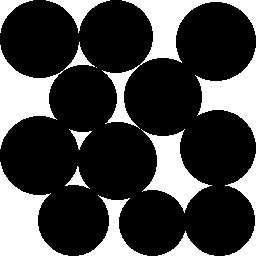

In [15]:
max_index = radii.sum(dim=1).argmax()
visualize_circles_image(circle_positions[max_index], radii[max_index])

# Minimal fit circles in the most dense variant
Just to check whether the circles are not too small 

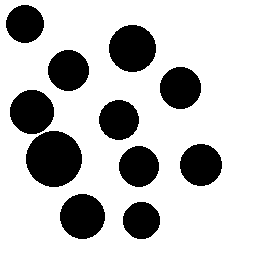

In [17]:

min_index = radii.sum(dim=1).argmin()
visualize_circles_image(circle_positions[min_index], radii[min_index])